In [1]:
import math
import numpy as np
from qiskit import Aer
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, assemble, Aer
from qiskit import execute
from qiskit.circuit.add_control import add_control
from qiskit.extensions import *
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.providers.ibmq.job import job_monitor
from qiskit.compiler import transpile
from qiskit.quantum_info import Statevector
from qiskit.providers.ibmq import RunnerResult

In [231]:
def controlSgate(x):
    return Operator([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0,math.sqrt((x-1)/x), 1/math.sqrt(x)],
                    [0, 0, -1/math.sqrt(x), math.sqrt((x-1)/x)]
                    ])

def storage(qc, v):
    n = int(math.log(len(v))/math.log(2))
    ss = sum(v)
    if v[0] == 0:
        qc.h(range(n))
        statevector = math.sqrt(2**n) * Statevector(qc)
        data_base_state =  Statevector(v)
        projector = data_base_state.to_operator()
        state = 1/math.sqrt(ss**3) * statevector.evolve(projector)
    else:
        statevector = Statevector(qc)
        data_base_state =  Statevector(v)
        projector = data_base_state.to_operator()
        state = 1/math.sqrt(ss) * statevector.evolve(projector)
    qc.initialize(state)
    return qc


def groupStorage(qc, v):
    n = int(math.log(len(v))/math.log(2))
    ss = sum(v)
    qc.h(range(n))
    statevector = math.sqrt(2**n) * Statevector(qc)
    data_base_state =  Statevector(v)
    projector = data_base_state.to_operator()
    state = 1/math.sqrt(ss**3) * statevector.evolve(projector)
    qc.initialize(state)
    return qc

#---------------------------------------------------------------
def stringBinanyComparison(n, target, val):
    target = target[::-1]
    #quantum register
    cqreg = QuantumRegister(1, name="c")
    mqreg = QuantumRegister(n, name="m")
    iqreg = QuantumRegister(n, name="i")

    # classical registers
    ccreg = ClassicalRegister(1, name="cc")
    mcreg = ClassicalRegister(n, name="mc")


    qc_m = QuantumCircuit(mqreg)
    qc = QuantumCircuit(iqreg, mqreg, cqreg, mcreg, ccreg)
    
    #load the target
    v = np.zeros(n)
    for l in range(len(target)):
         if target[l] =='1':
            qc.x(iqreg[l])
            v[l] = 1

    qc_m.compose(storage(qc_m, val))
    qc = qc.compose(qc_m, mqreg)

    qc.h(cqreg)
    #qc.barrier()
    #--------------------------
    for j in range(n):
        if v[j] == 1:
            qc.cx(iqreg[j], mqreg[j])
        qc.x(mqreg[j])

    #qc.barrier()
    U = Operator([[math.e ** (complex(0, 1) * math.pi / (2 * n)), 0],[0, 1]])
    for j in range(n):
        qc.unitary(U, mqreg[j], label='U')

    Um = Operator([[1 / math.e ** (complex(0, 1) * math.pi /n), 0],[0, 1]])
    u = UnitaryGate(Um)
    cu = add_control(u, 1, '$CU^{-2}$', '1')

    for j in range(n):
        qc.append(cu, [cqreg, mqreg[j]])
    #qc.barrier()
    for j in range(n):
        qc.x(mqreg[j])
        if v[j] == 1:
            qc.cx(iqreg[j], mqreg[j])
    qc.h(cqreg)
    
    #qc.barrier()
    qc.measure(cqreg,ccreg)
    qc.measure(mqreg, mcreg)
    return qc



#---------------------------------------------------------------
def groupStringBinanyComparison(n, val, val2):
    #quantum register
    cqreg = QuantumRegister(1, name="c")
    mqreg = QuantumRegister(n, name="m")
    iqreg = QuantumRegister(n, name="i")

    # classical registers
    ccreg = ClassicalRegister(1, name="cc")
    mcreg = ClassicalRegister(n, name="mc")


    qc_m = QuantumCircuit(mqreg)
    qc_i = QuantumCircuit(iqreg)
    qc = QuantumCircuit(iqreg, mqreg, cqreg, mcreg, ccreg)
    

    qc_m.compose(groupStorage(qc_m, val))
    qc_i.compose(groupStorage(qc_i, val2))
    qc = qc.compose(qc_m, mqreg)
    qc = qc.compose(qc_i, iqreg)

    qc.h(cqreg[0])
    #qc.barrier()
    #--------------------------
    for j in range(n):
        qc.cx(iqreg[j], mqreg[j])
        qc.x(mqreg[j])

    #qc.barrier()
    U = Operator([[math.e ** (complex(0, 1) * math.pi / (2 * n)), 0],[0, 1]])
    for j in range(n):
        qc.unitary(U, mqreg[j], label='U')

    Um = Operator([[1 / math.e ** (complex(0, 1) * math.pi /n), 0],[0, 1]])
    u = UnitaryGate(Um)
    cu = add_control(u, 1, '$CU^{-2}$', '1')

    for j in range(n):
        qc.append(cu, [cqreg, mqreg[j]])
    #qc.barrier()
    for j in range(n):
        qc.x(mqreg[j])
        qc.cx(iqreg[j], mqreg[j])
    qc.h(cqreg)
    
    #qc.barrier()
    qc.measure(cqreg,ccreg)
    qc.measure(mqreg, mcreg)
    return qc


In [220]:
#your provider
#IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q-sherbrooke', group='cmc-microsystems', project='optimization')
backend = provider.get_backend('ibmq_qasm_simulator')

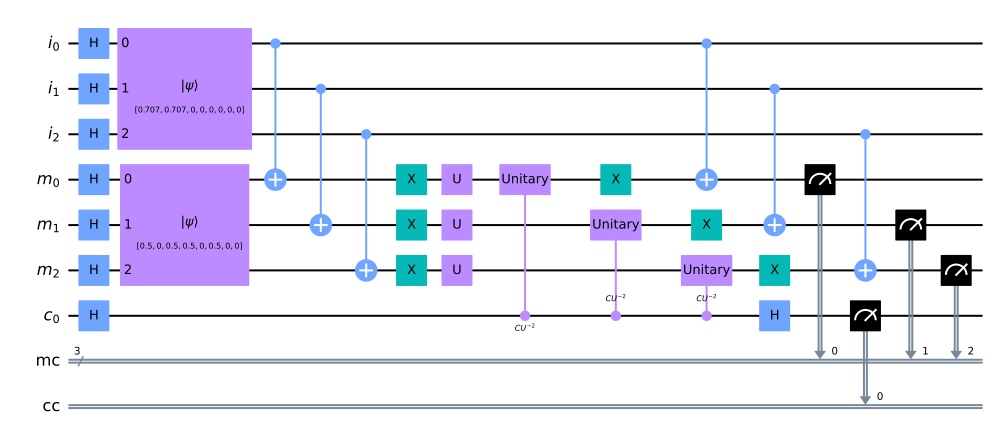

In [249]:

data_base_values=[1, 0, 1, 1, 0, 1, 0, 0]
target_values=[1, 1, 0, 0, 0, 0, 0, 0]
n = int(math.log(len(data_base_values))/math.log(2)) 
qc = groupStringBinanyComparison(n, data_base_values, target_values)
qc.draw()

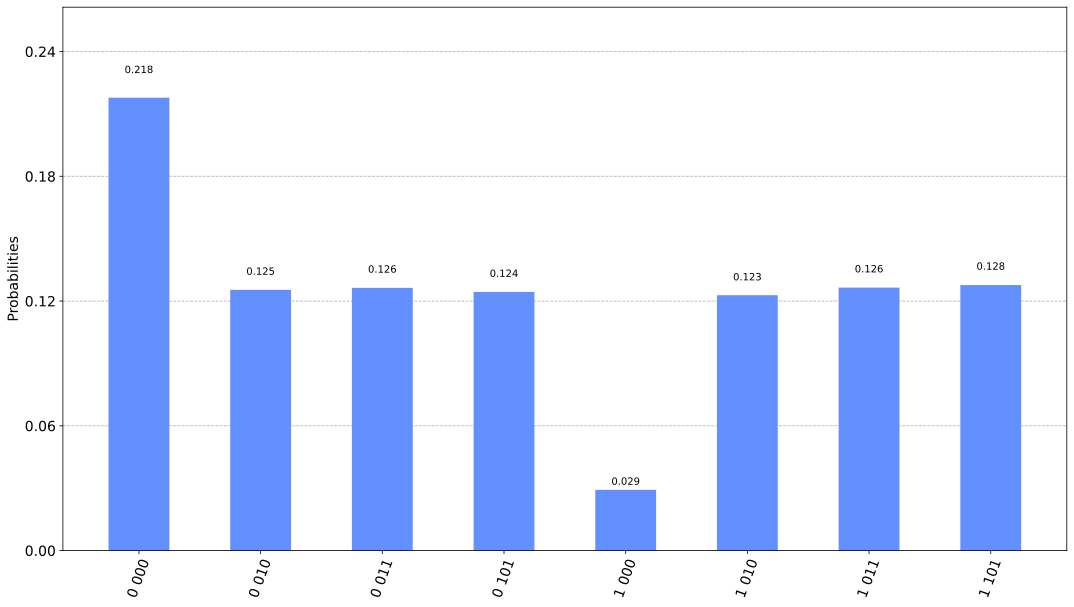

In [250]:
backend = provider.get_backend('ibmq_qasm_simulator')
job= execute(qc, backend, shots=8192)
result = job.result()
counts = result.get_counts()
plot_histogram(counts, figsize=[18, 10])

In [252]:
backend = provider.get_backend('ibmq_montreal')
qc_transpiled = transpile(qc, backend , optimization_level=2)

print("The TRANSPILED circuit depth is:", qc_transpiled.depth())

The TRANSPILED circuit depth is: 96


In [253]:
backend = provider.get_backend('ibmq_montreal')
circuit = []
depth_list = []
for _ in range(50):
    qc1 = transpile(qc, backend , optimization_level=2)
    depth_list.append(qc1.depth())
    circuit.append(qc1)
qctf = circuit[depth_list.index(min(depth_list))]

print("The TRANSPILED circuit depth is:", qctf.depth())

The TRANSPILED circuit depth is: 84


In [254]:
backend = provider.get_backend('ibmq_montreal')
job= execute(qctf, backend, shots=32000)
job_monitor(job)


Job Status: job has successfully run                  


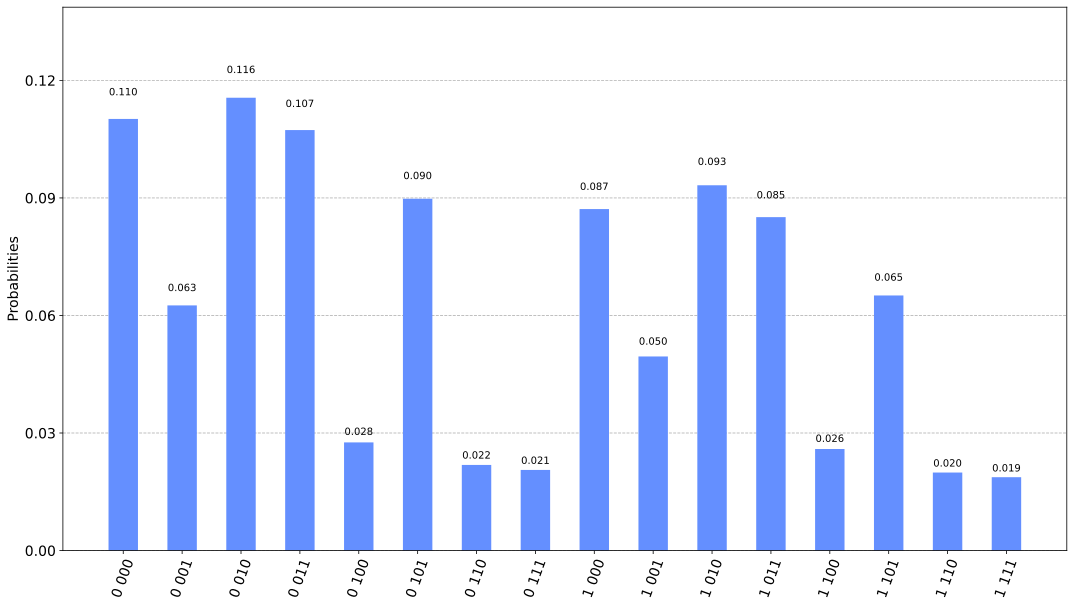

In [255]:
result = job.result()
counts = result.get_counts()
plot_histogram(counts, figsize=[18, 10])

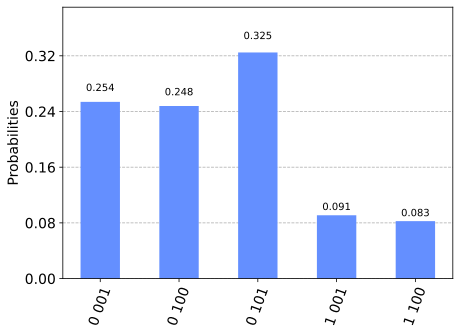

In [16]:
backend = provider.get_backend('ibmq_qasm_simulator')
job= execute(qc, backend, shots=8192)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

ON REAL DEVICE (we can do better when we include layout and error mitigation)

In [25]:
backend = provider.get_backend('ibmq_toronto')
qc_transpiled = transpile(qc, backend , optimization_level=2, initial_layout = [10, 12, 13, 7, 15, 14, 11])
print("The TRANSPILED circuit depth is:", qc_transpiled.depth())

The TRANSPILED circuit depth is: 57


In [ ]:
backend = provider.get_backend('ibmq_toronto')
job= execute(qc_transpiled, backend, shots=8192)
job_monitor(job)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

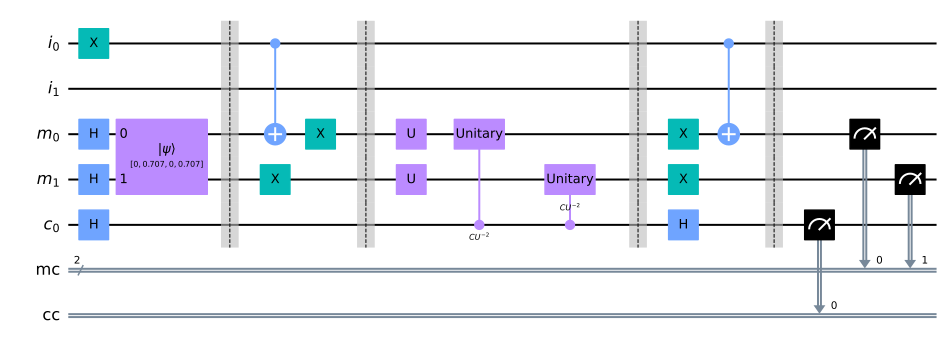

In [152]:
target_binary = "01"  # not in the data base
n = len(target_binary)
values=[0, 1, 0, 1] 
qc = stringBinanyComparison(n, target_binary, values)
qc.draw()

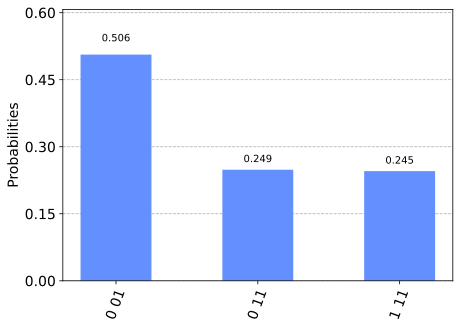

In [153]:
backend = provider.get_backend('ibmq_qasm_simulator')
job= execute(qc, backend, shots=8192)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [154]:
backend = provider.get_backend('ibmq_montreal')
qc_transpiled = transpile(qc, backend , optimization_level=2, initial_layout = [7, 10, 12, 15, 13])
print("The TRANSPILED circuit depth is:", qc_transpiled.depth())

The TRANSPILED circuit depth is: 36


Job Status: job has successfully run                        


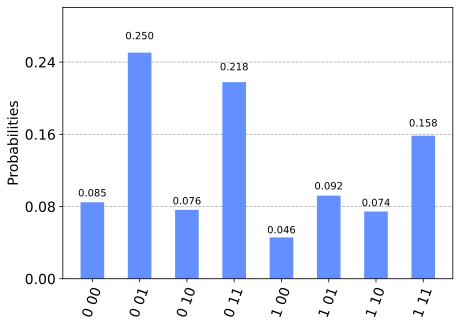

In [155]:
backend = provider.get_backend('ibmq_montreal')
job= execute(qc_transpiled, backend, shots=8192)
job_monitor(job)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)